# Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

# Importing

In [94]:
import pandas as pd
import numpy as np
import bamboolib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import kpss, adfuller
from pylab import rcParams
import statsmodels.api as sm

In [95]:
# Opening JSON file
with open('logins.json') as d:
    data_json = json.load(d)

In [96]:
data_json

{'login_time': ['1970-01-01 20:13:18',
  '1970-01-01 20:16:10',
  '1970-01-01 20:16:37',
  '1970-01-01 20:16:36',
  '1970-01-01 20:26:21',
  '1970-01-01 20:21:41',
  '1970-01-01 20:12:16',
  '1970-01-01 20:35:47',
  '1970-01-01 20:35:38',
  '1970-01-01 20:47:52',
  '1970-01-01 20:26:05',
  '1970-01-01 20:31:03',
  '1970-01-01 20:34:46',
  '1970-01-01 20:36:34',
  '1970-01-01 20:39:25',
  '1970-01-01 20:40:37',
  '1970-01-01 20:34:58',
  '1970-01-01 20:43:59',
  '1970-01-01 20:47:46',
  '1970-01-01 20:46:34',
  '1970-01-01 20:56:07',
  '1970-01-01 20:49:12',
  '1970-01-01 20:59:06',
  '1970-01-01 20:59:59',
  '1970-01-01 21:15:01',
  '1970-01-01 21:09:24',
  '1970-01-01 21:19:24',
  '1970-01-01 21:20:53',
  '1970-01-01 21:29:19',
  '1970-01-01 21:58:05',
  '1970-01-01 21:51:51',
  '1970-01-01 21:59:40',
  '1970-01-01 22:08:34',
  '1970-01-01 22:02:51',
  '1970-01-01 21:58:32',
  '1970-01-01 22:02:31',
  '1970-01-01 22:05:32',
  '1970-01-01 22:02:46',
  '1970-01-01 22:10:28',
  '1970-01-

In [97]:
df = pd.DataFrame.from_records(data_json)

In [98]:
df

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [100]:
df['login_time'] = pd.to_datetime(df['login_time'], infer_datetime_format=True)
df.set_index('login_time', inplace=True)

# Aggregating Data

In [101]:
agg_15m = pd.DataFrame(df.groupby(pd.Grouper(freq='15Min')).size())

In [102]:
agg_15m = agg_15m.rename(columns={'0': 'count'})
agg_15m

,0
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


# Visualizations

The following plot visualizes the login counts in 15 minute intervals. It's clear that there is an element of cyclicality to the data, but further investigation is needed to reveal the details of the cycilcality.

Text(22.5379224537037, 0.5, 'Login Count')

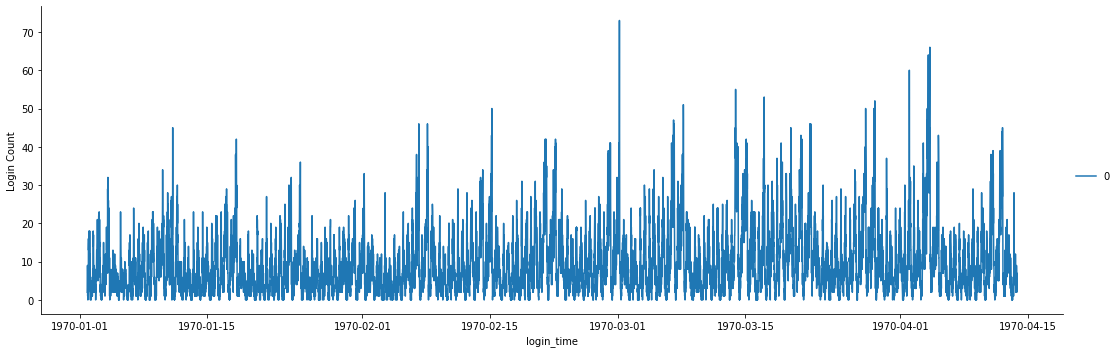

In [129]:
sns.relplot(data = agg_15m, kind='line', aspect = 3)
plt.ylabel('Login Count')

Zooming in to a random day reveals the details of the cyclicality. Increased amounts of logins are observed around noon and midnight of each day.

Text(22.5379224537037, 0.5, 'Login Count')

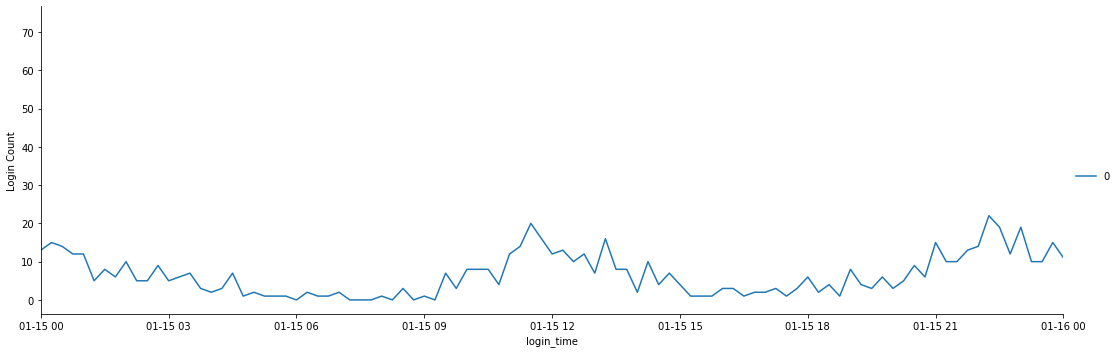

In [145]:
sns.relplot(data = agg_15m, kind='line', aspect = 3)
plt.xlim('1970-01-15', '1970-01-16')
plt.ylabel('Login Count')

The KPSS and ADFuller tests can be used to evaluate stationarity. The p-values of the KPSS test (0.01) and the ADFuller p-value (2.7e-18) suggest trend stationarity, not strict stationarity.

In [126]:
kpss(agg_15m)

(2.9895998153342602,
 0.01,
 38,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [105]:
adfuller(agg_15m)

(-10.337954309060441,
 2.7323966542230642e-18,
 38,
 9749,
 {'1%': -3.431020942932955,
  '5%': -2.8618365160244372,
  '10%': -2.5669278303551253},
 56368.34584451129)

The decomposition of the data on a daily frequency reveal a trend that had low daily login counts in the winter months. The trend of login counts increased in the early months of spring, peaking in March.

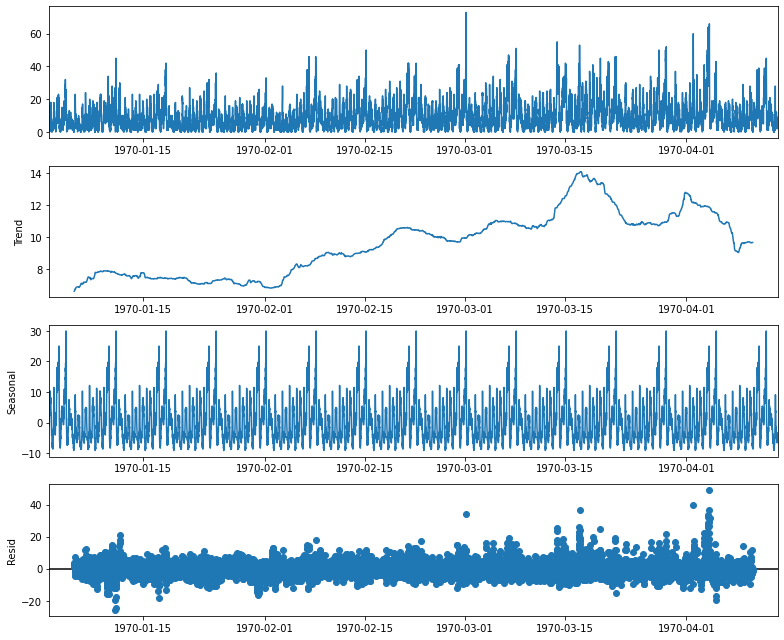

In [115]:
rcParams['figure.figsize'] = 11,9
decomp = sm.tsa.seasonal_decompose(agg_15m, period = 672, model = 'additive')
decomp.plot()
plt.show()

Lastly, plotting the autocorrelations might be useful for identifying lag values for an ARMA model, but the nature of the PACF does not support any lag values since the PACF coefficients show an oscillation of significant values.

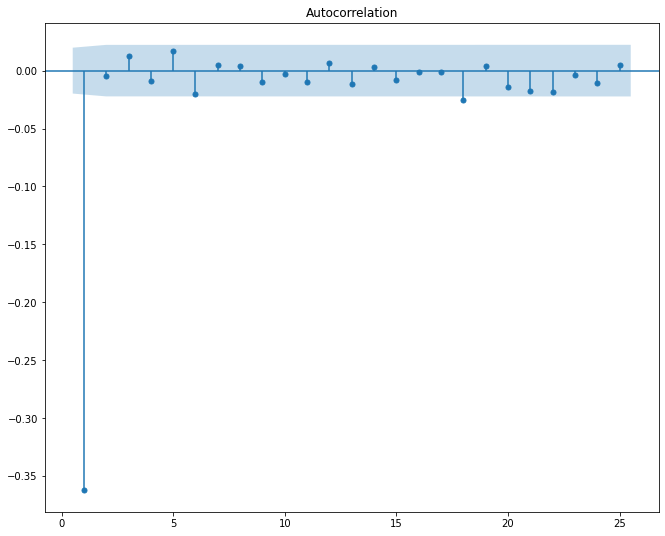

In [150]:
tsaplots.plot_acf(agg_15m.diff().dropna(), lags=25, zero=False)
plt.show()

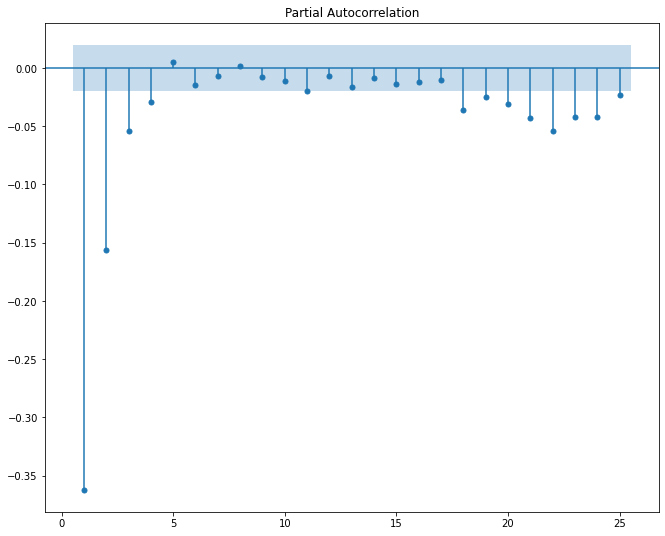

In [149]:
tsaplots.plot_pacf(agg_15m.diff().dropna(), lags=25, zero=False)
plt.show()